In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 6
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 6


In [2]:
npl = 2
datadir = "./kep9/"
names = ['ttv-b.txt', 'ttv-c.txt']

In [3]:
tcobs, errorobs, p_init = [], [], []
for n in names:
    fname = datadir + n
    _d = pd.read_csv(fname, delim_whitespace=True)
    tnum, tc, tcerr = np.array(_d[['N', 'T0', 'sigma_T0']]).T
    tcerr /= 1440.
    tcobs.append(tc)
    errorobs.append(tcerr)
    p, t0 = np.polyfit(tnum, tc, deg=1)
    p_init.append(p)
p_init = np.array(p_init)

In [4]:
import itertools
tclist = list(itertools.chain.from_iterable(tcobs))
print (p_init[0], p_init[0]/40.)
print (np.min(tclist), np.max(tclist))

19.246113950740433 0.48115284876851083
136.30647 1587.53394


In [5]:
dt = 0.4 #/ 2.
t_start, t_end = 135, 1590.
jttv = jaxttv(t_start, t_end, dt)

# sympletic integrator is used.


In [6]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.4000 (1/48 of innermost period)


initial objective function: 63542598.52 (107 data)

running LM optimization...
objective function: 144.24 (107 data)
# elapsed time (least square): 9.5 sec


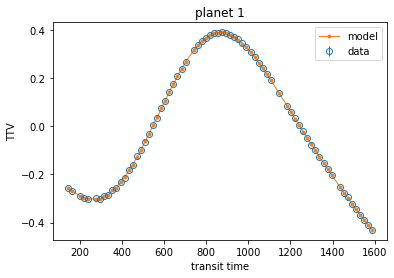

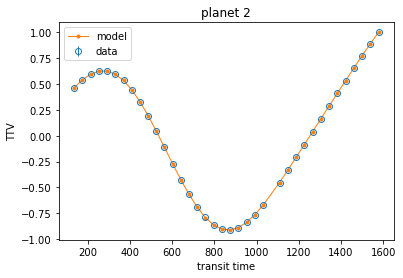

In [7]:
params_best = jttv.optim(amoeba=False, mmax=1e-3, emax=0.2)

In [8]:
tc = jttv.check_prec(params_best)

# fractional energy error (symplectic, dt=4.00e-01): 1.48e-08
# fractional energy error (Hermite, dt=1.92e-02): -1.64e-11
# max difference in tc: 7.32e-05 days (6.33 sec)


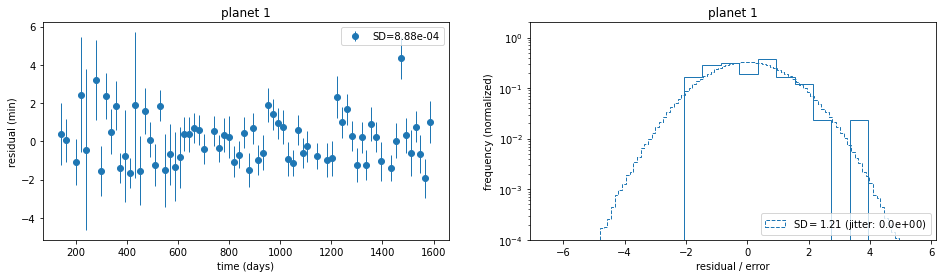

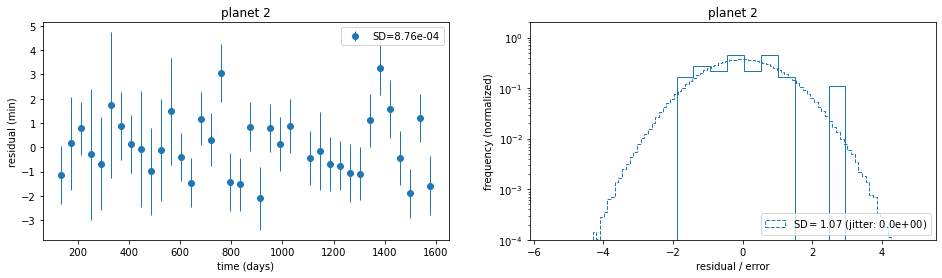

In [9]:
# cf. Figure 6/7 left in Borasto+2019 arXiv:1901.05471
jttv.check_residuals(tc)

In [10]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

       pmass     period     ecosw     esinw  cosi  lnode         tic  \
0  42.478714  19.228894  0.063156 -0.003492  -0.0   -0.0  144.249596   
1  29.252036  39.037223 -0.066577  0.013400   0.0    0.0  136.307117   

        ecc     omega    lnmass      mass      cosw      sinw  
0  0.063253 -0.055241 -8.966733  0.000128  0.998475 -0.055212  
1  0.067912  2.942972 -9.339787  0.000088 -0.980340  0.197317  


In [11]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

5.17 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    #elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    elements = jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [13]:
pdic_init

{'period': DeviceArray([19.22889369, 39.03722321], dtype=float64),
 'cosi': DeviceArray([-0.,  0.], dtype=float64),
 'lnode': DeviceArray([-0.,  0.], dtype=float64),
 'tic': DeviceArray([144.2495958 , 136.30711683], dtype=float64),
 'ecc': DeviceArray([0.06325298, 0.06791213], dtype=float64),
 'lnmass': DeviceArray([-8.96673274, -9.33978666], dtype=float64),
 'mass': DeviceArray([1.27584363e-04, 8.78581775e-05], dtype=float64),
 'cosw': DeviceArray([ 0.99847463, -0.98033977], dtype=float64),
 'sinw': DeviceArray([-0.05521245,  0.19731684], dtype=float64)}

In [14]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [32]:
nw, ns, linm, tcjitter = 100, 100, True, None  # dt=0.4, 1h20min
nw, ns, linm, tcjitter = 500, 500, True, 1e-3  # dt=0.4, x6, 12hr (A100)
nw, ns, linm, tcjitter = 500, 500, True, None  # dt=0.4, x6, 14hr (A100)

In [33]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [34]:
output = "kep9/dt%.1f_"%jttv.dt
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit_"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [35]:
output
#output = "kep9/linm_n500x4_"

'kep9/dt0.4_nw500_ns500_c6_'

In [36]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2022-04-27 08:12:05.826465: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module pmap__unnamed_wrapped_function___1.117120
********************************


In [47]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      0.93      0.22      0.92      0.55      1.29      3.90      2.78
   cosw[1]     -0.97      0.11     -0.97     -1.14     -0.74      4.70      2.54
    ecc[0]      0.06      0.00      0.06      0.06      0.07     19.13      1.38
    ecc[1]      0.07      0.00      0.07      0.07      0.07     87.75      1.06
   mass[0]      0.00      0.00      0.00      0.00      0.00     19.40      1.37
   mass[1]      0.00      0.00      0.00      0.00      0.00     19.42      1.37
 period[0]     19.23      0.00     19.23     19.23     19.23     22.32      1.25
 period[1]     39.04      0.00     39.04     39.04     39.04     19.78      1.30
   sinw[0]     -0.05      0.01     -0.05     -0.06     -0.03      6.10      1.67
   sinw[1]      0.20      0.02      0.20      0.15      0.23      4.69      2.54
    tic[0]    144.25      0.00    144.25    144.25    144.25    128.96      1.08
    tic[1]    136.31      0

In [38]:
samples = mcmc.get_samples()

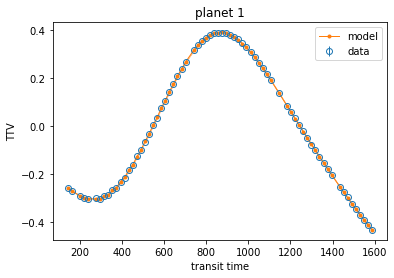

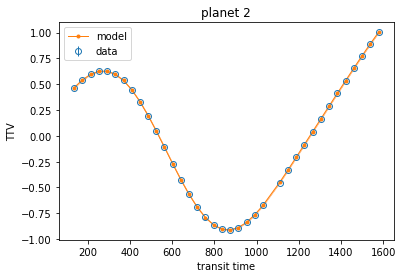

In [39]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=output+"postm")

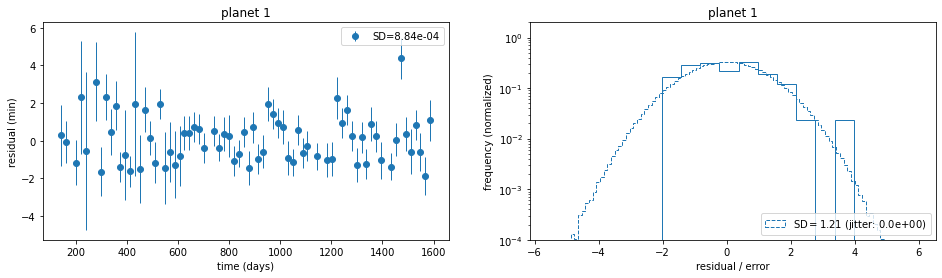

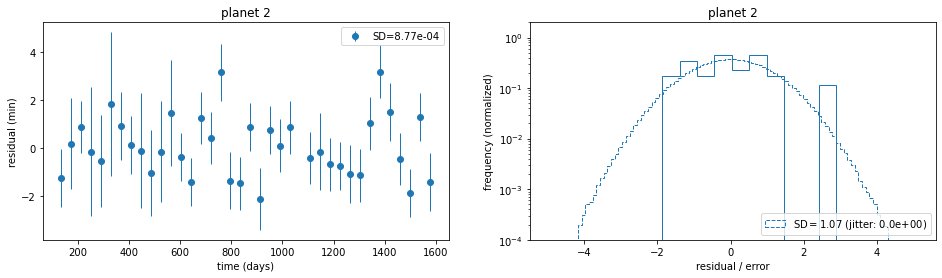

In [40]:
jttv.check_residuals(mmodel)

(array([ 47., 124., 535., 593., 696., 562., 286., 111.,  33.,  13.]),
 array([-7.84720233, -7.84373263, -7.84026294, -7.83679325, -7.83332355,
        -7.82985386, -7.82638417, -7.82291447, -7.81944478, -7.81597509,
        -7.81250539]),
 <BarContainer object of 10 artists>)

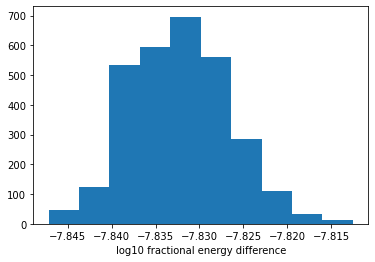

In [41]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [42]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

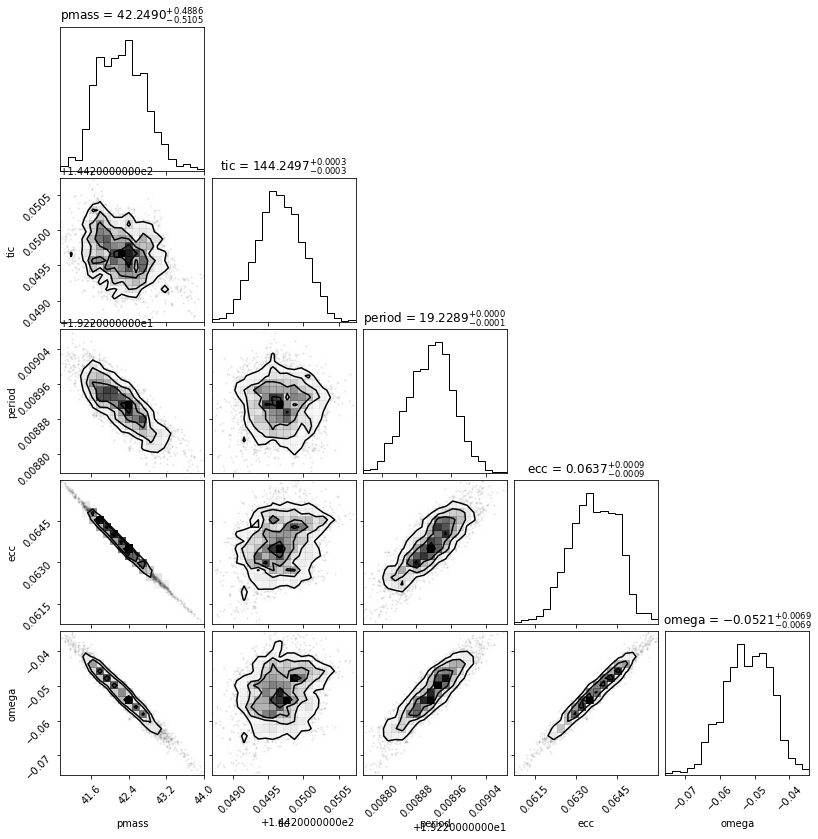

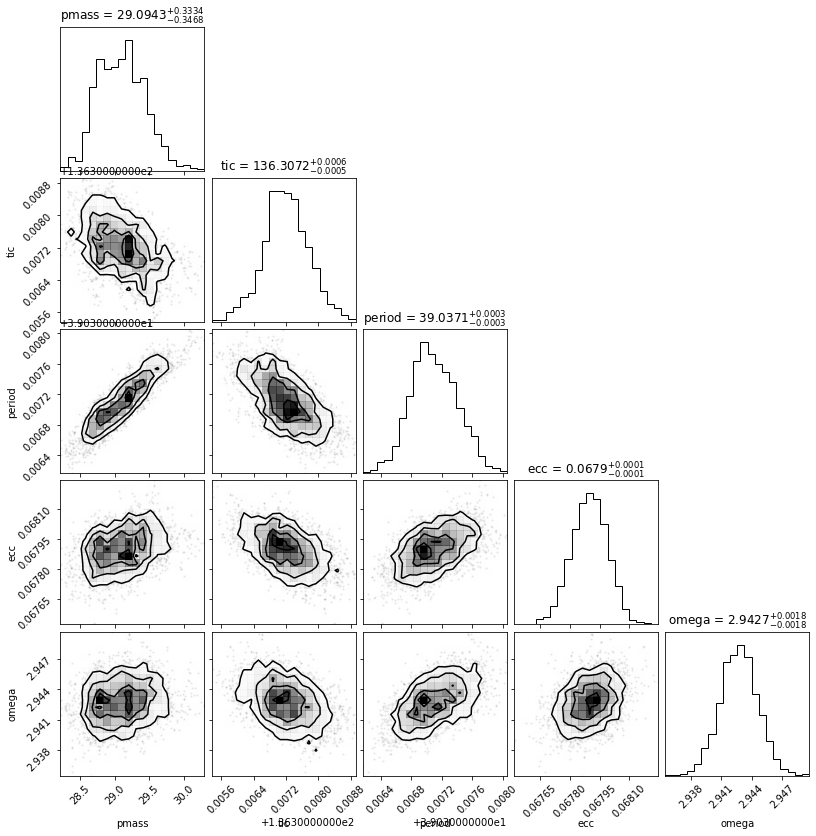

In [43]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

### check convergence of transit times

In [44]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.0400 (1/481 of innermost period)


(array([32.,  9., 12., 24.,  6.,  3.,  2.,  2.,  3., 14.]),
 array([-3.46672183, -2.49844351, -1.53016519, -0.56188688,  0.40639144,
         1.37466975,  2.34294807,  3.31122639,  4.2795047 ,  5.24778302,
         6.21606133]),
 <BarContainer object of 10 artists>)

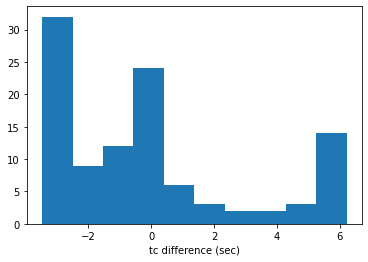

In [45]:
k = 50
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)